# Experiment AAMAS


1. [Reproducing the Braess paradox](#braess_paradox)
2. [Computation time of algorithms to compute Nash equibrium in N-player and mean field games as a function of the number of players](#efficiency)
3. [Sioux Falls, 14,000 vehicles with MFG](#sioux_falls)
4. [Augmented Braess network with multiple origin destinations](#multiple_destinations)
5. [Average deviation of the mean field equilibrium policy in the N-player Pigou network game as a function of N](#pigou_deviation)
6. [Average deviation of the mean field equilibrium policy in the N-player Braess network game as a function of N](#braess_deviation)


## 0. Importing libraries
If the import does not work please download and compile open spiel from source and check if you have all the required libraries.

In [1]:
import matplotlib.pyplot as plt
import time

In [2]:
from open_spiel.python import policy as policy_module
from open_spiel.python.algorithms import best_response as best_response_module
from open_spiel.python.algorithms import expected_game_score
from open_spiel.python.games import dynamic_routing_to_mean_field_game
from open_spiel.python.mfg.algorithms import distribution as distribution_module
from open_spiel.python.mfg.algorithms import nash_conv as nash_conv_module
from open_spiel.python.mfg.algorithms import policy_value
from open_spiel.python.mfg.games import dynamic_routing as mean_field_routing_game

from utils import *

Instructions for updating:
non-resource variables are not supported in the long term


<a name='braess_paradox'></a>

## 1. Reproducing the Braess paradox with the mean field routing game

This is used to produce figure 1 of the AAMAS article.

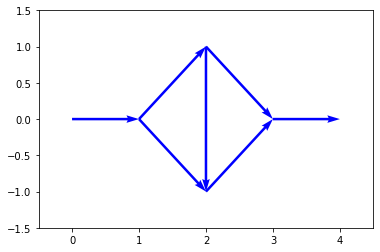

In [3]:
BRAESS_NUM_VEHICLES = 4
BRAESS_ORIGIN = 'A->B'
BRAESS_DESTINATION = 'E->F'
BRAESS_TIME_STEP_LENGTH = 0.25
BRAESS_MAX_TIME_STEP = int(4.0/BRAESS_TIME_STEP_LENGTH) + 1

BRAESS_GRAPH = create_braess_network(BRAESS_NUM_VEHICLES)
plot_network_n_player_game(BRAESS_GRAPH)

BRAESS_GAME, BRAESS_SEQ_GAME, BRAESS_MFG_GAME = create_games(
    BRAESS_ORIGIN, BRAESS_DESTINATION, BRAESS_NUM_VEHICLES, BRAESS_GRAPH, BRAESS_MAX_TIME_STEP,
    BRAESS_TIME_STEP_LENGTH)

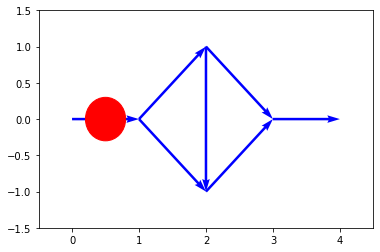

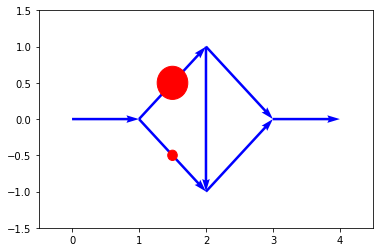

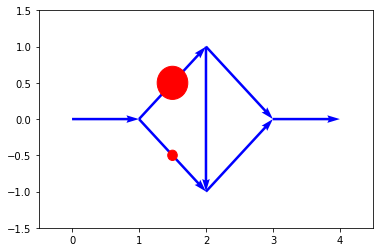

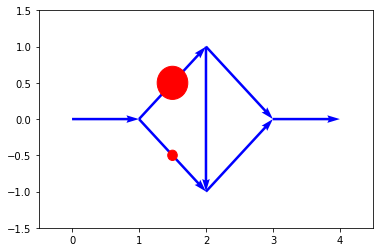

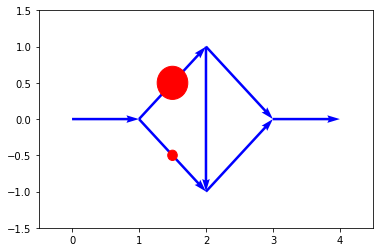

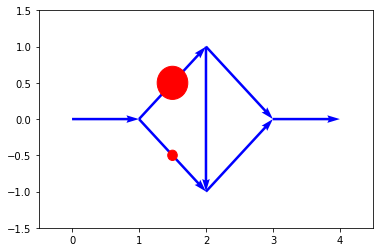

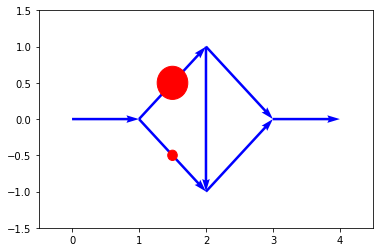

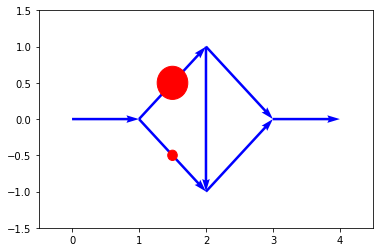

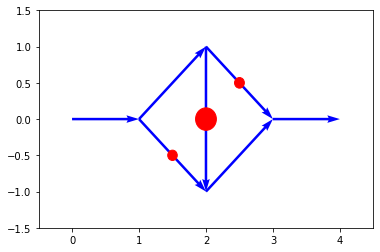

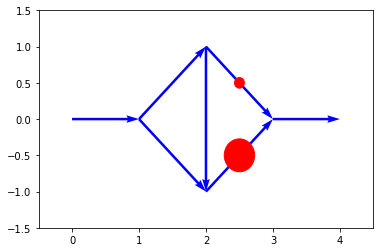

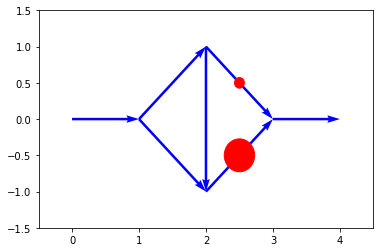

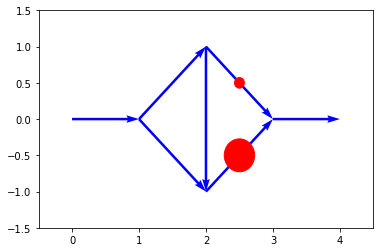

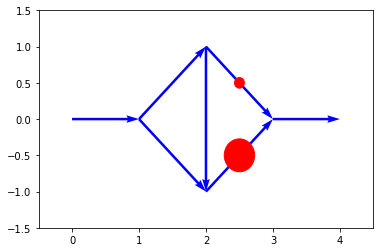

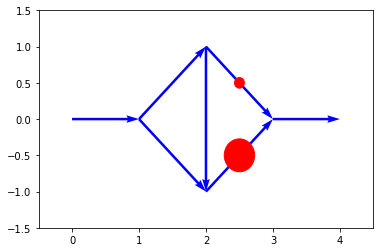

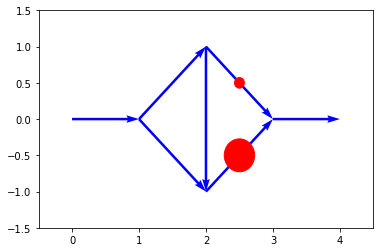

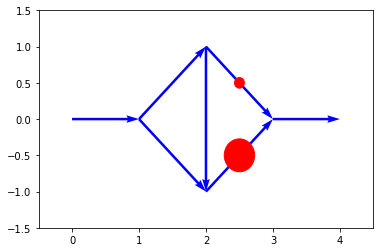

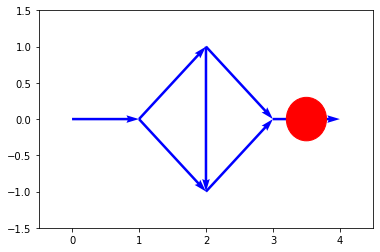

In [4]:
# Online Mirror Descent

md_p_init = mirror_descent.MirrorDescent(BRAESS_MFG_GAME, lr=1)
mfmd_timing, mfmd_policy, mfmd_nash_conv, mfmd_policy_value, md_p = online_mirror_descent(
    BRAESS_MFG_GAME, 10, compute_metrics=True, return_policy=True, md_p=md_p_init)
evolve_mean_field_game(BRAESS_MFG_GAME, mfmd_policy, BRAESS_GRAPH)

<a name='efficiency'></a>
## 2. Computation time of algorithms to compute Nash equibrium in N-player and mean field games as a function of the number of players.

This is used to produce figure 2 of the AAMAS article.


In [5]:
timing_n_player_results = {}
timing_mean_field_results = {}
NUM_ALGO_ITERATIONS = 10

for num_vehicles in range(5, 45, 5):
  braess_game, braess_seq_game, braess_mfg_game = create_games(
      BRAESS_ORIGIN, BRAESS_DESTINATION, num_vehicles, BRAESS_GRAPH, BRAESS_MAX_TIME_STEP,
      BRAESS_TIME_STEP_LENGTH)
  ext_cfr_timing, ext_cfr_policy = external_sampling_monte_carlo_counterfactual_regret_minimization(braess_seq_game, NUM_ALGO_ITERATIONS)
  mfmd_timing, mfmd_policy = online_mirror_descent(braess_mfg_game, NUM_ALGO_ITERATIONS, compute_metrics=False)
  timing_n_player_results[num_vehicles] = ext_cfr_timing
  timing_mean_field_results[num_vehicles] = mfmd_timing

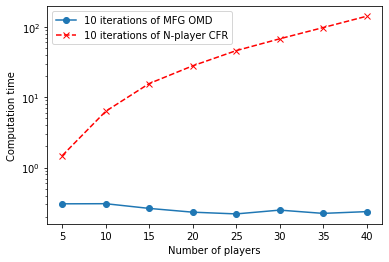

In [6]:
plt.plot(list(timing_mean_field_results), list(timing_mean_field_results.values()), '-o', label=f'{NUM_ALGO_ITERATIONS} iterations of MFG OMD')
plt.plot(list(timing_n_player_results), list(timing_n_player_results.values()), '--xr', label=f'{NUM_ALGO_ITERATIONS} iterations of N-player CFR')
plt.legend()
plt.yscale('log')
plt.xlabel('Number of players')
plt.ylabel('Computation time')
plt.show()

<a name='sioux_falls'></a>
## 3. Solving large games with mean field online mirror descent algorithm: 14,000 vehicles in the Sioux Falls network

This is used to produce figure 4 and 5 of the AAMAS article.
Depending on the computer used, the computation can take a long time. On the MacBook Pro 2019 with macOS Big Sur 11.6 it tooks around 10 hours.


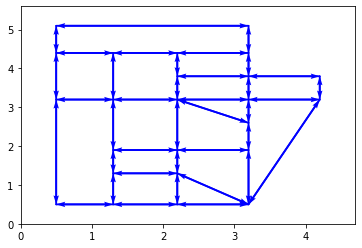

In [7]:
SIOUX_FALLS_GRAPH, SIOUX_FALLS_OD_DEMAND = create_sioux_falls_network()
plot_network_n_player_game(SIOUX_FALLS_GRAPH)

SIOUX_FALLS_OD_DEMAND = [
    dynamic_routing_utils.OriginDestinationDemand(f'bef_19->19', f'1->aft_1', 0, 7000),
    dynamic_routing_utils.OriginDestinationDemand(f'bef_1->1', f'19->aft_19', 0, 7000)
]

SIOUX_FALLS_TIME_STEP_LENGTH = 0.5  # 0.2
SIOUX_FALLS_MAX_TIME_STEP = int(40.0/SIOUX_FALLS_TIME_STEP_LENGTH) + 1  # 0.25

SIOUX_MFG_GAME = mean_field_routing_game.MeanFieldRoutingGame(
    {"max_num_time_step": SIOUX_FALLS_MAX_TIME_STEP, "time_step_length": SIOUX_FALLS_TIME_STEP_LENGTH},
    network=SIOUX_FALLS_GRAPH, od_demand=SIOUX_FALLS_OD_DEMAND)



In [ ]:
def online_mirror_descent_sioux_falls(mfg_game,
                                      number_of_iterations,
                                      md_p=None):
  nash_conv_dict = {}
  md = md_p if md_p else mirror_descent.MirrorDescent(mfg_game)
  tick_time = time.time()
  for i in range(number_of_iterations):
    if i < 32:
      md.iteration(learning_rate=1)
    elif i < 64:
      md.iteration(learning_rate=0.1)
    else:
      md.iteration(learning_rate=0.01)
    md_policy = md.get_policy()
    nash_conv_md = nash_conv_module.NashConv(mfg_game, md_policy)
    nash_conv_dict[i] = nash_conv_md.nash_conv()
    print((f"Iteration {i}, Nash conv: {nash_conv_md.nash_conv()}, "
           f"time: {time.time() - tick_time}"))
  timing = time.time() - tick_time
  md_policy = md.get_policy()
  distribution_mfg = distribution_module.DistributionPolicy(mfg_game, md_policy)
  policy_value_ = policy_value.PolicyValue(
      mfg_game, distribution_mfg, md_policy).value(mfg_game.new_initial_state())
  nash_conv_md = nash_conv_module.NashConv(mfg_game, md_policy)
  return timing, md_policy, nash_conv_md, policy_value_, md, nash_conv_dict

md_p_init = mirror_descent.MirrorDescent(SIOUX_MFG_GAME, lr=1)
mfmd_timing, mfmd_policy, mfmd_nash_conv, mfmd_policy_value, md_p, nash_conv_dict = online_mirror_descent_sioux_falls(
    SIOUX_MFG_GAME, 100, md_p=md_p_init)

print(f"Online mirror descent nash conv: {mfmd_nash_conv.nash_conv()}")
print(f"Online mirror descent timing: {mfmd_timing}")

tick_time = time.time()
evolve_mean_field_game(SIOUX_MFG_GAME, mfmd_policy, SIOUX_FALLS_GRAPH)
print(time.time() - tick_time)



In [ ]:
plt.plot(list(nash_conv_dict), list(nash_conv_dict.values()), 'x') #, label='Online mirror descent')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Average deviation incentive')
plt.show()



<a name='multiple_destinations'></a>
## 4. Augmented Braess network with multiple origin destinations.

This is used to produce figure 7 of the AAMAS article.

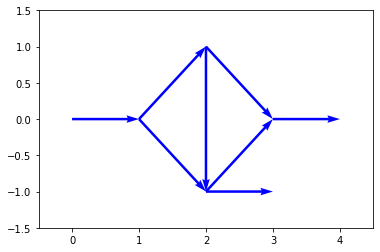

In [8]:
AUG_BRAESS_GRAPH = create_augmented_braess_network(150)
plot_network_n_player_game(AUG_BRAESS_GRAPH)

AUG_BRAESS_OD_DEMAND = [
    dynamic_routing_utils.OriginDestinationDemand('A->B', 'E->F', 0, 50),
    dynamic_routing_utils.OriginDestinationDemand('A->B', 'E->F', 0.5, 50),
    dynamic_routing_utils.OriginDestinationDemand('A->B', 'E->F', 1, 50),
    dynamic_routing_utils.OriginDestinationDemand('A->B', 'D->G', 0, 50),
    dynamic_routing_utils.OriginDestinationDemand('A->B', 'D->G', 1, 50)]

AUG_BRAESS_TIME_STEP_LENGTH = 0.05
AUG_BRAESS_MAX_TIME_STEP = int(8.0/AUG_BRAESS_TIME_STEP_LENGTH) + 1

AUG_BRAESS_MFG_GAME = mean_field_routing_game.MeanFieldRoutingGame(
    {"max_num_time_step": AUG_BRAESS_MAX_TIME_STEP, "time_step_length": AUG_BRAESS_TIME_STEP_LENGTH},
    network=AUG_BRAESS_GRAPH, od_demand=AUG_BRAESS_OD_DEMAND)

/Users/theophile/Desktop/AAMAS/utils.py:489: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


Online mirror descent nash conv: 0.22690646124560976
Online mirror descent timing: 91.26232719421387


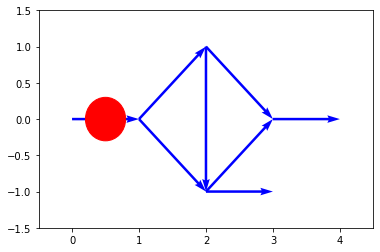

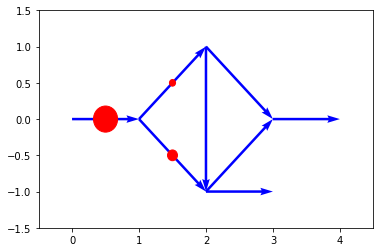

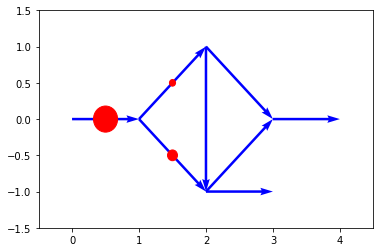

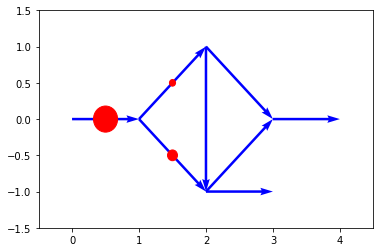

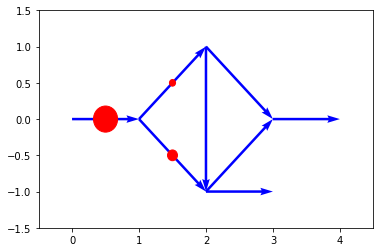

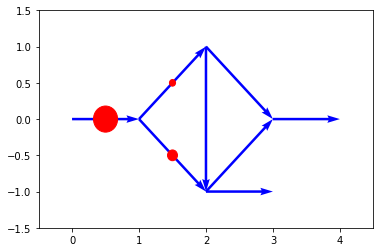

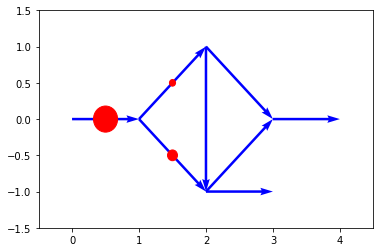

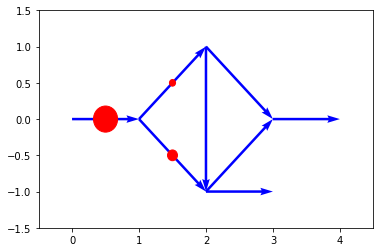

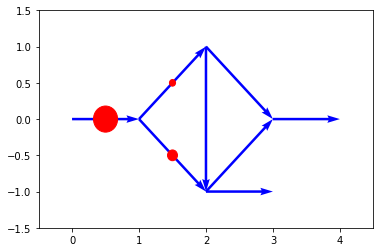

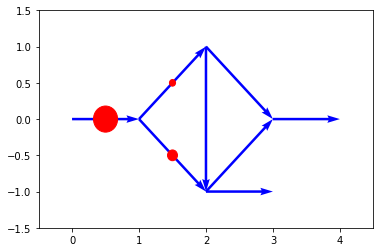

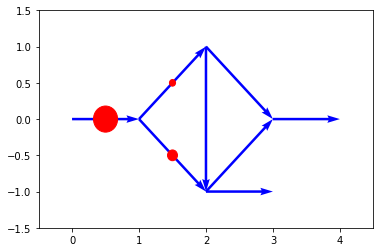

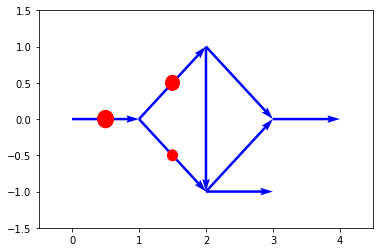

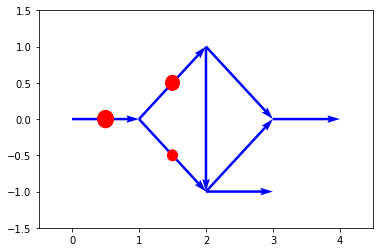

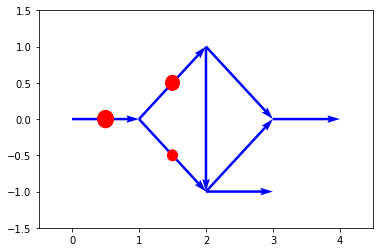

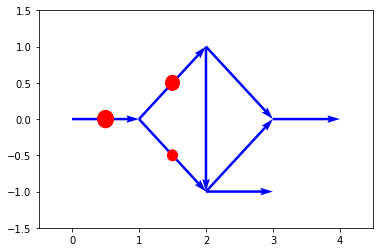

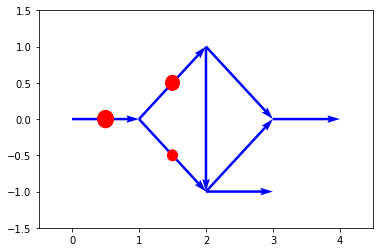

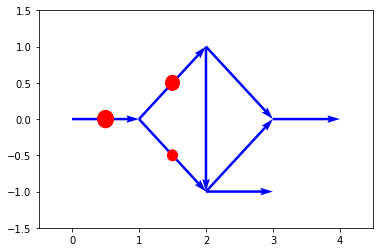

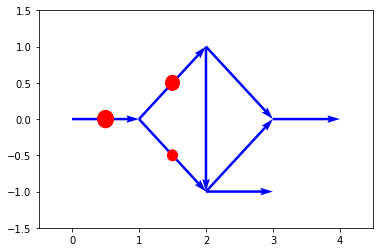

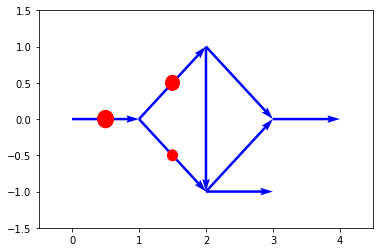

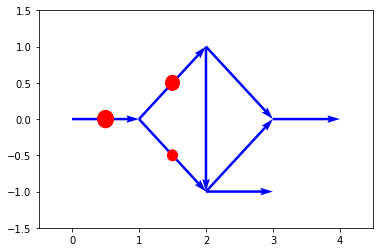

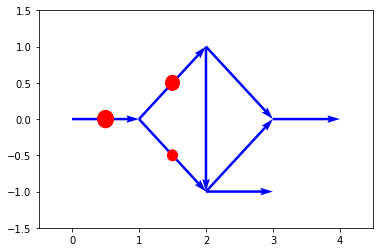

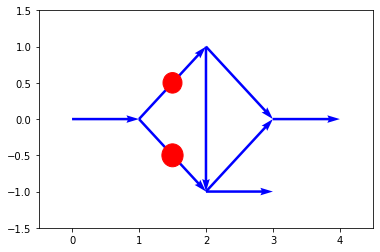

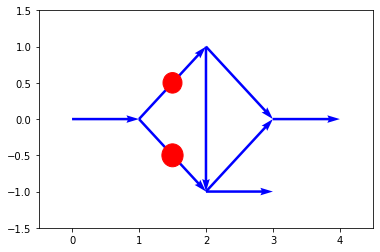

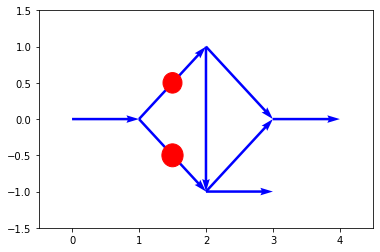

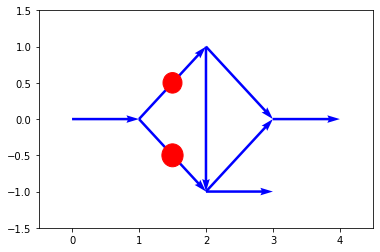

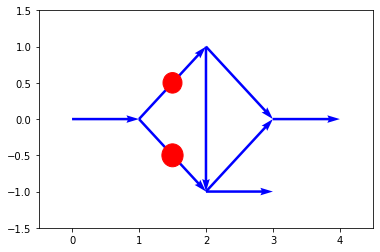

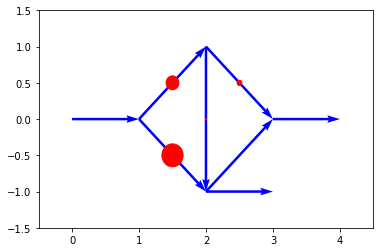

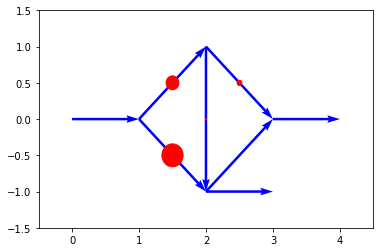

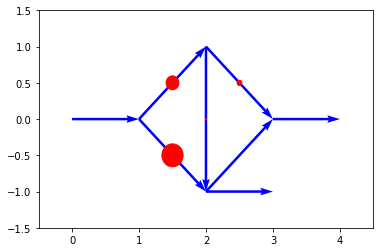

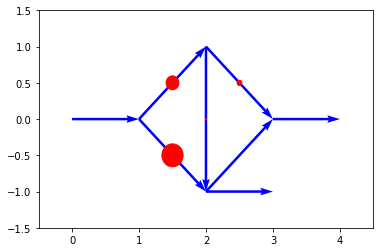

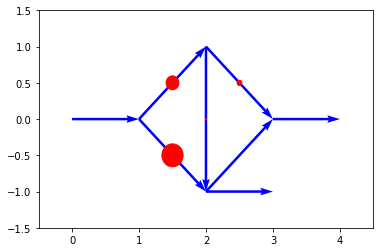

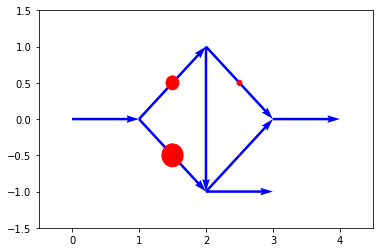

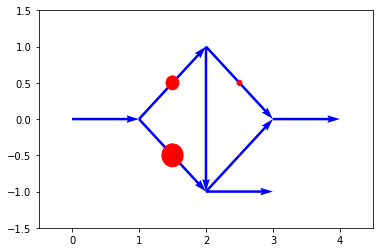

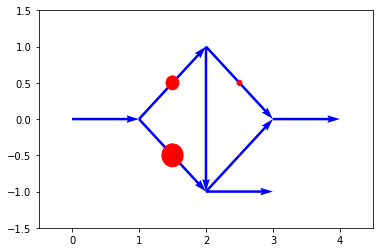

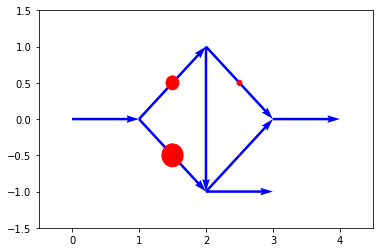

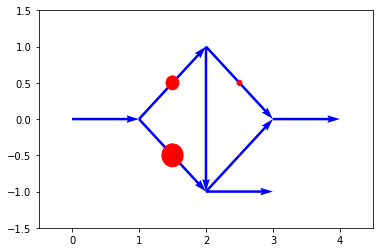

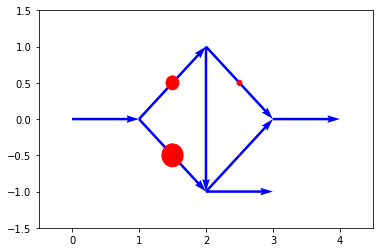

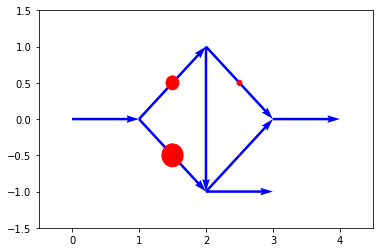

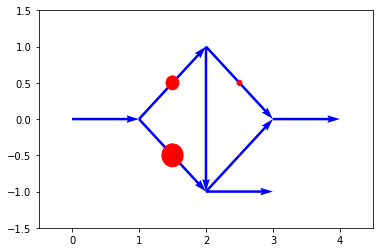

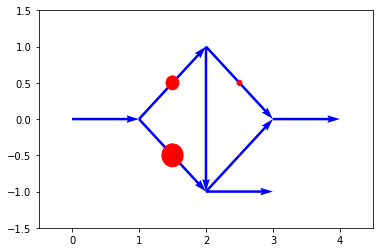

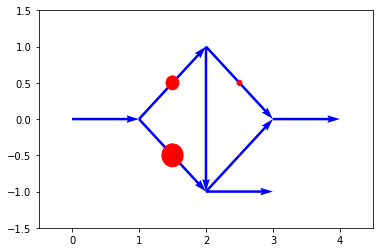

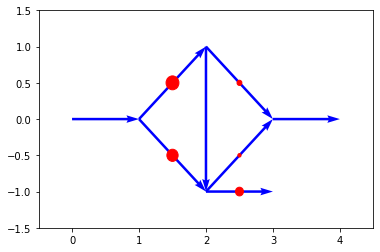

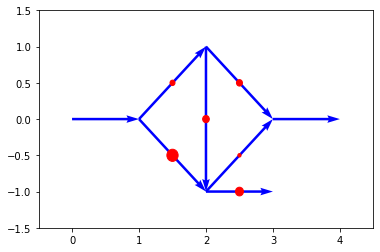

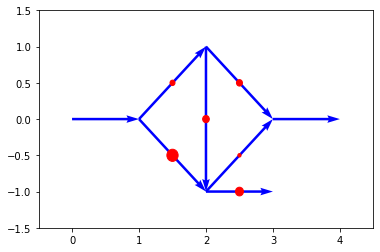

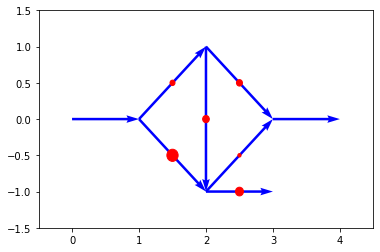

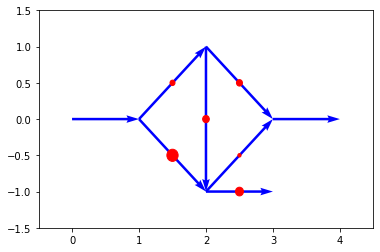

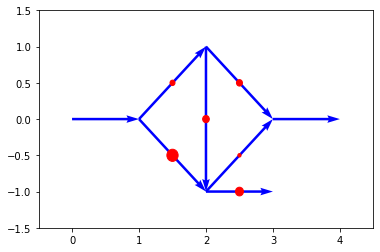

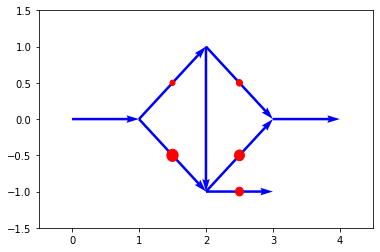

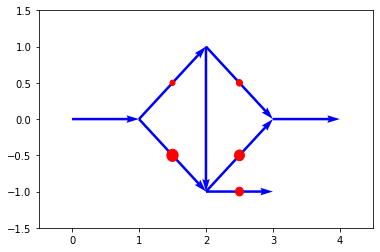

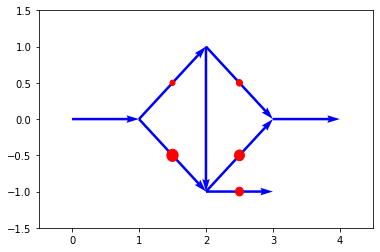

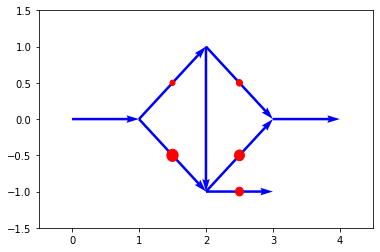

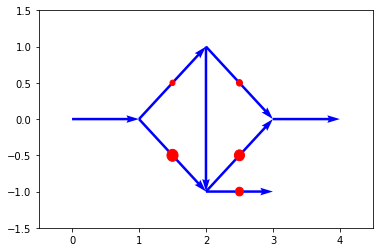

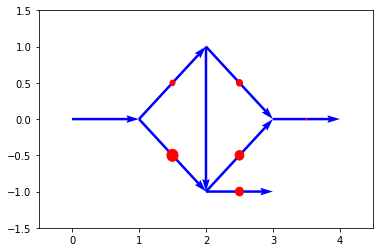

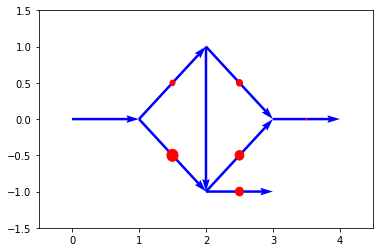

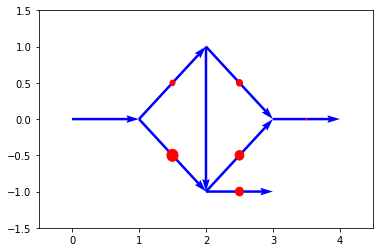

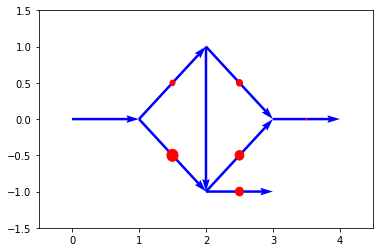

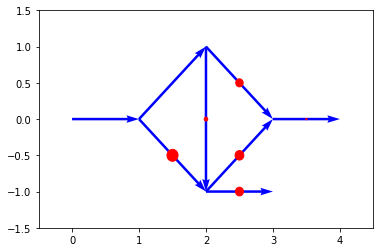

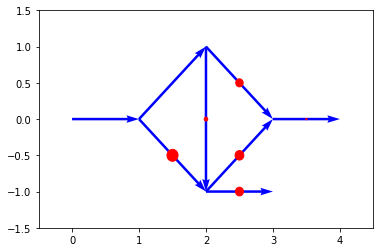

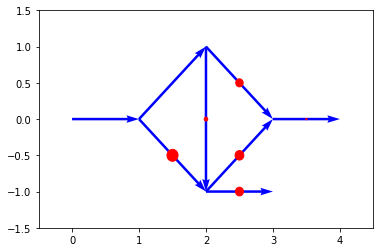

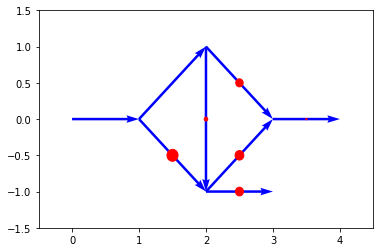

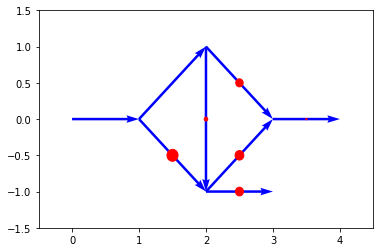

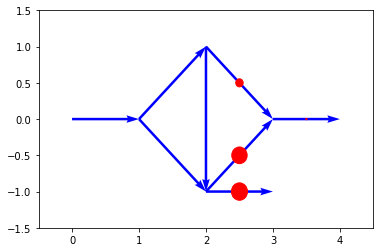

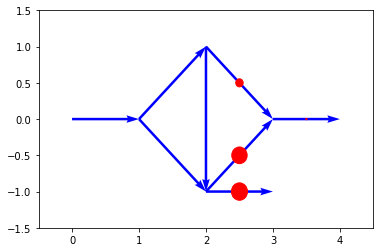

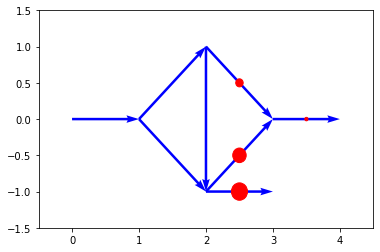

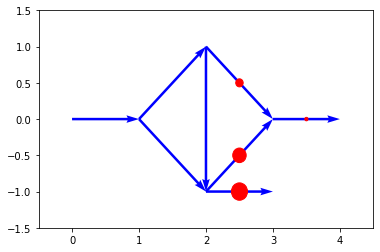

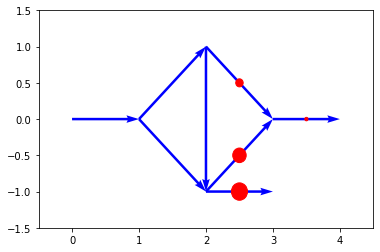

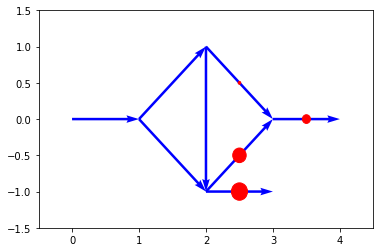

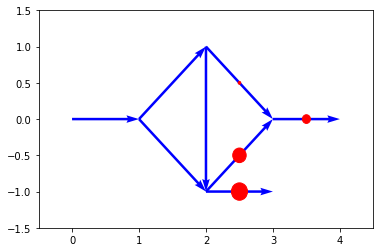

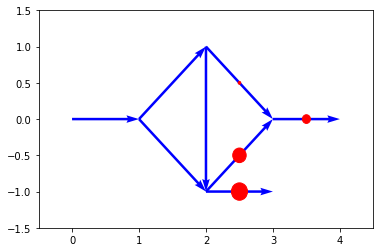

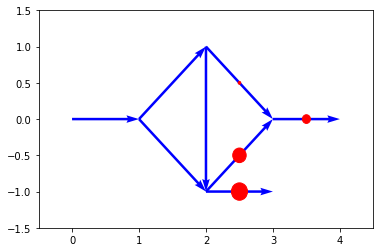

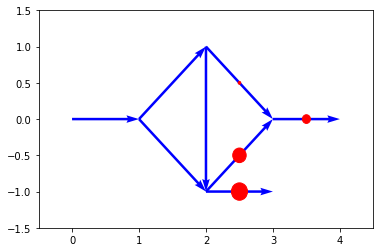

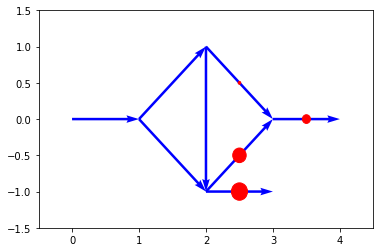

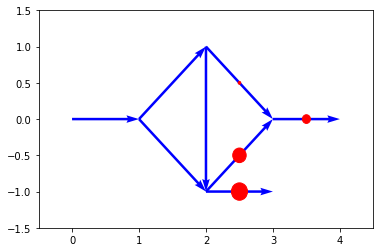

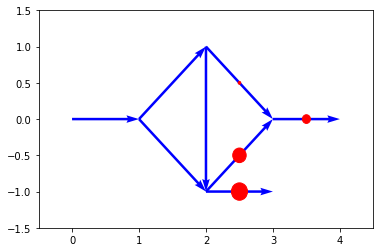

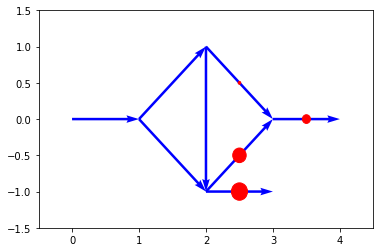

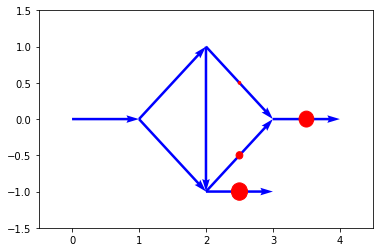

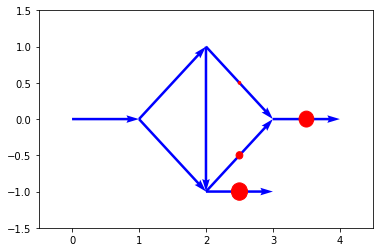

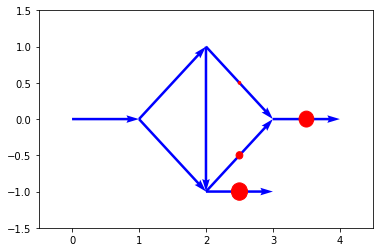

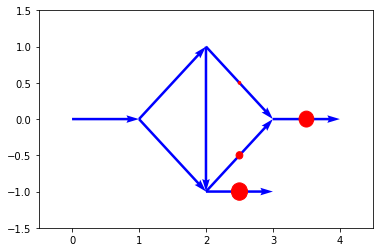

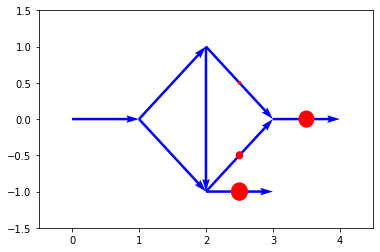

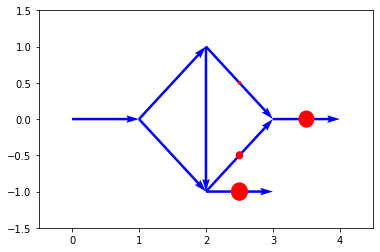

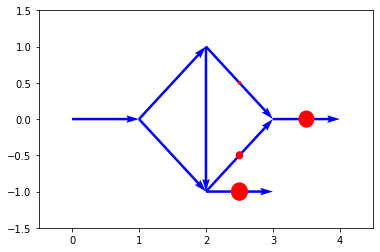

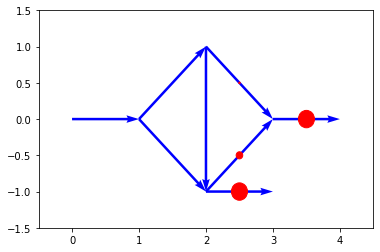

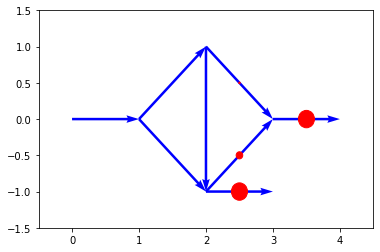

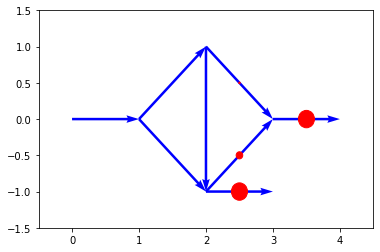

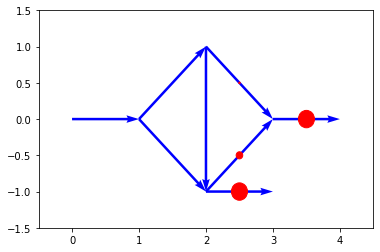

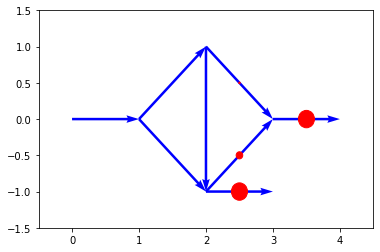

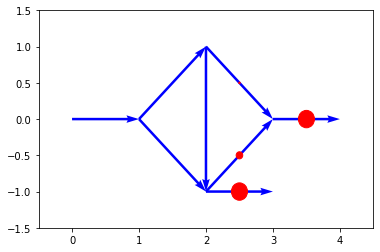

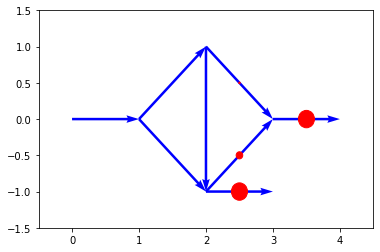

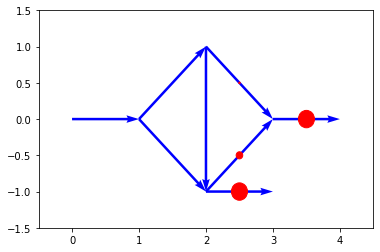

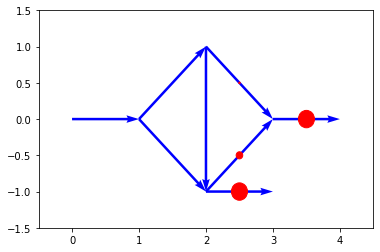

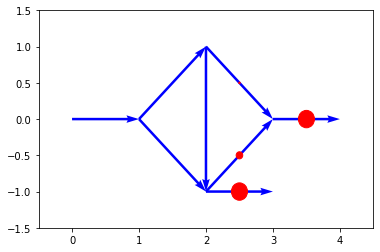

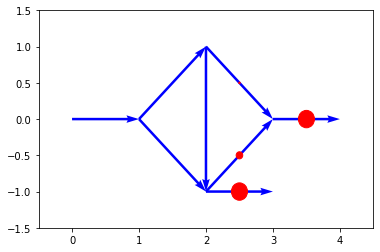

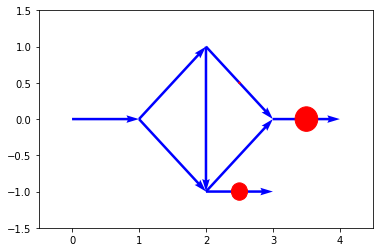

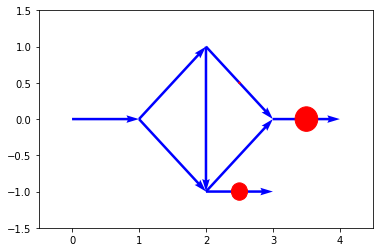

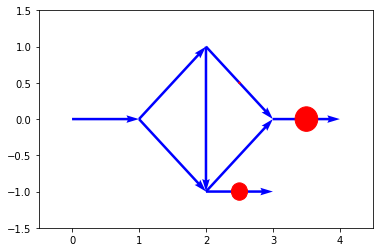

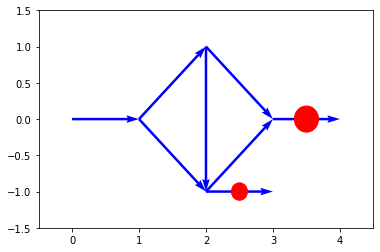

In [9]:
# Online Mirror Descent

md_p_init = mirror_descent.MirrorDescent(AUG_BRAESS_MFG_GAME, lr=1)
mfmd_timing, mfmd_policy, mfmd_nash_conv, mfmd_policy_value, md_p = online_mirror_descent(
    AUG_BRAESS_MFG_GAME, 20, compute_metrics=True, return_policy=True, md_p=md_p_init)
evolve_mean_field_game(AUG_BRAESS_MFG_GAME, mfmd_policy, AUG_BRAESS_GRAPH)

print(f"Online mirror descent nash conv: {mfmd_nash_conv.nash_conv()}")
print(f"Online mirror descent timing: {mfmd_timing}")

<a name='pigou_deviation'></a>
## 5. Average deviation of the mean field equilibrium policy in the N-player Pigou network game as a function of N.

This is used to produce figure 3 of the AAMAS article.

In [12]:
def create_series_parallel_network(num_network_in_series,
                                   time_step_length=1,
                                   capacity=1):
  i = 0
  origin = "A_0->B_0"
  graph_dict = {}
  while i < num_network_in_series:
    graph_dict.update({
        f"A_{i}": {
            "connection": {
                f"B_{i}": {
                    "a": 0,
                    "b": 1.0,
                    "capacity": capacity,
                    "free_flow_travel_time": time_step_length
                }
            },
            "location": [0 + 3 * i, 0]
        },
        f"B_{i}": {
            "connection": {
                f"C_{i}": {
                    "a": 0.0,
                    "b": 1.0,
                    "capacity": capacity,
                    "free_flow_travel_time": 2.0
                },
                f"D_{i}": {
                    "a": 2.0,
                    "b": 1.0,
                    "capacity": capacity,
                    "free_flow_travel_time": 1.0
                }
            },
            "location": [1 + 3 * i, 0]
        },
        f"C_{i}": {
            "connection": {
                f"A_{i+1}": {
                    "a": 0,
                    "b": 1.0,
                    "capacity": capacity,
                    "free_flow_travel_time": time_step_length
                }
            },
            "location": [2 + 3 * i, 1]
        },
        f"D_{i}": {
            "connection": {
                f"A_{i+1}": {
                    "a": 0,
                    "b": 1.0,
                    "capacity": capacity,
                    "free_flow_travel_time": time_step_length
                }
            },
            "location": [2 + 3 * i, -1]
        }
    })
    i += 1
  graph_dict[f"A_{i}"] = {
      "connection": {
          "END": {
              "a": 0,
              "b": 1.0,
              "capacity": capacity,
              "free_flow_travel_time": time_step_length
          }
      },
      "location": [0 + 3 * i, 0]
  }
  graph_dict["END"] = {"connection": {}, "location": [1 + 3 * i, 0]}
  time_horizon = int(5.0 * (num_network_in_series + 1) / time_step_length)
  destination = f"A_{i}->END"
  adjacency_list = {
      key: list(value["connection"].keys())
      for key, value in graph_dict.items()
  }
  bpr_a_coefficient = {}
  bpr_b_coefficient = {}
  capacity = {}
  free_flow_travel_time = {}
  for o_node, value_dict in graph_dict.items():
    for d_node, section_dict in value_dict["connection"].items():
      road_section = dynamic_routing_utils._nodes_to_road_section(
          origin=o_node, destination=d_node)
      bpr_a_coefficient[road_section] = section_dict["a"]
      bpr_b_coefficient[road_section] = section_dict["b"]
      capacity[road_section] = section_dict["capacity"]
      free_flow_travel_time[road_section] = section_dict[
          "free_flow_travel_time"]
  node_position = {key: value["location"] for key, value in graph_dict.items()}
  return dynamic_routing_utils.Network(
      adjacency_list,
      node_position=node_position,
      bpr_a_coefficient=bpr_a_coefficient,
      bpr_b_coefficient=bpr_b_coefficient,
      capacity=capacity,
      free_flow_travel_time=free_flow_travel_time
  ), origin, destination, time_horizon

In [13]:
class GoUp(PurePolicyResponse):

  def pure_action(self, state):
    location = state.get_current_vehicle_locations()[self.player_id].split(
        "->")[1]
    if location == "B_0":
      return state.get_game().network.get_action_id_from_movement("B_0", "C_0")
    else:
      return 0

def compute_regret_policy_against_pure_policy_pigou_sim_game(game,
                                                            policy,
                                                            compute_true_value=False,
                                                            num_sample=100):
  time_tick = time.time()
  if compute_true_value:
    expected_value_policy = expected_game_score.policy_value(
        game.new_initial_state(), policy)[0]
  else:
    expected_value_policy = get_expected_value_sim_game(game, policy, num_sample)
  worse_regret = 0
  deviation_policy = GoUp(game, policy, 0)
  if compute_true_value:
    expected_value_noise = expected_game_score.policy_value(
        game.new_initial_state(), deviation_policy)[0]
  else:
    expected_value_noise = get_expected_value_sim_game(
        game, deviation_policy, num_sample, player=0)
  approximate_regret = expected_value_noise - expected_value_policy
  worse_regret = max(worse_regret, approximate_regret)
  return worse_regret, time.time() - time_tick

In [14]:
num_of_tests = 5

computation_time_pure_policy_nash_conv_dict_large = {}
pure_policy_nash_conv_n_player_dict_large = {}

PIGOU_TIME_STEP_LENGTH = 0.05

for pigou_num_vehicle in [x for x in range(1, 10, 1)] + [x for x in range(10, 100, 10)]:
  PIGOU_GRAPH, PIGOU_ORIGIN, PIGOU_DESTINATION, PIGOU_MAX_TIME_STEP = create_series_parallel_network(
  1, time_step_length=PIGOU_TIME_STEP_LENGTH, capacity=pigou_num_vehicle)

  PIGOU_GAME, PIGOU_SEQ_GAME, PIGOU_MFG_GAME = create_games(
        PIGOU_ORIGIN, PIGOU_DESTINATION, pigou_num_vehicle, PIGOU_GRAPH, PIGOU_MAX_TIME_STEP,
        PIGOU_TIME_STEP_LENGTH)

  md_p_init = mirror_descent.MirrorDescent(PIGOU_MFG_GAME, lr=1)
  mfmd_timing, mfmd_policy, mfmd_nash_conv, mfmd_policy_value, md_p = online_mirror_descent(
      PIGOU_MFG_GAME, 10, compute_metrics=True, return_policy=True, md_p=md_p_init)
  print(f"Online mirror descent nash conv: {mfmd_nash_conv.nash_conv()}")
  mfmd_policy_n_player_derived = dynamic_routing_to_mean_field_game.DerivedNPlayerPolicyFromMeanFieldPolicy(
        PIGOU_GAME, mfmd_policy)

  nash_conv_n_player_list = []
  computation_time_list = []

  # nash_conv_n_player, computation_time = compute_regret_policy_against_pure_policy_pigou_sim_game(
  #   PIGOU_GAME, mfmd_policy_n_player_derived, compute_true_value=True)
  for _ in range(num_of_tests):
    nash_conv_n_player, computation_time = compute_regret_policy_against_pure_policy_pigou_sim_game(
      PIGOU_GAME, mfmd_policy_n_player_derived, compute_true_value=False)
    nash_conv_n_player_list.append(nash_conv_n_player)
    computation_time_list.append(computation_time)
    print(f"Sampled exploitability: {nash_conv_n_player}, computed in {computation_time}")
  computation_time_pure_policy_nash_conv_dict_large[pigou_num_vehicle] = computation_time_list
  pure_policy_nash_conv_n_player_dict_large[pigou_num_vehicle] = nash_conv_n_player_list



Online mirror descent nash conv: 0.0
Sampled exploitability: 0.4700000000000015, computed in 0.9756557941436768
Sampled exploitability: 0.5600000000000018, computed in 0.8944790363311768
Sampled exploitability: 0.4200000000000017, computed in 0.9288721084594727
Sampled exploitability: 0.5000000000000018, computed in 0.9496140480041504
Sampled exploitability: 0.5400000000000018, computed in 0.9391789436340332
Online mirror descent nash conv: 0.0
Sampled exploitability: 0.31000000000000094, computed in 2.1634109020233154
Sampled exploitability: 0.20000000000000062, computed in 1.9562690258026123
Sampled exploitability: 0.30000000000000115, computed in 2.3220441341400146
Sampled exploitability: 0.28000000000000114, computed in 1.9844417572021484
Sampled exploitability: 0.2500000000000009, computed in 1.9949040412902832
Online mirror descent nash conv: 0.0
Sampled exploitability: 0.1029999999999971, computed in 3.1870689392089844
Sampled exploitability: 0.193499999999998, computed in 3.227

In [15]:
import scipy.special
import matplotlib.pyplot as plt
pigou_true_average_deviation_incentive = {}
for num_player in range(1, 100):
  probs = {}

  for x in range(num_player):
    probs[(x+1)/num_player] = scipy.special.binom(num_player-1, x)*(0.5**(num_player-1))

  assert abs(sum(probs.values())-1) < 1e-4
  e_tt = sum(p*(1.05+2*x) for x, p in probs.items())
  pigou_true_average_deviation_incentive[num_player] = (e_tt-2.05)/2



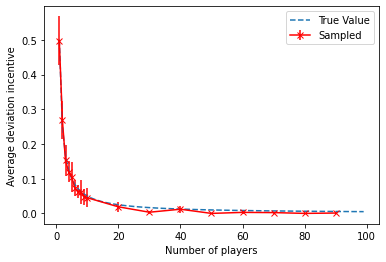

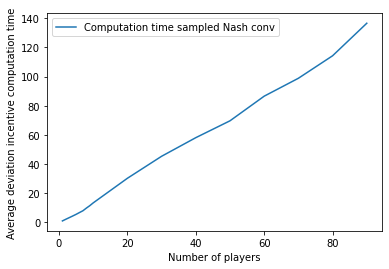

In [16]:

plt.errorbar(
    list(pure_policy_nash_conv_n_player_dict_large),
    [sum(x)/len(x) for x in pure_policy_nash_conv_n_player_dict_large.values()],
    yerr=[(max(x)-min(x))/2 for x in pure_policy_nash_conv_n_player_dict_large.values()], fmt='-xr', # ls='none',
    label='Sampled') #  (mean, min and max, 100 sampled, 5 times)
plt.plot(list(pigou_true_average_deviation_incentive), list(pigou_true_average_deviation_incentive.values()), '--', label='True Value')
plt.legend()
plt.xlabel('Number of players')
plt.ylabel('Average deviation incentive')  # of mean field equilibrium policy
plt.show()

plt.plot(list(computation_time_pure_policy_nash_conv_dict_large), list([sum(x)/len(x) for x in computation_time_pure_policy_nash_conv_dict_large.values()]), label='Computation time sampled Nash conv')
plt.legend()
plt.xlabel('Number of players')
plt.ylabel('Average deviation incentive computation time')
plt.show()

<a name='braess_deviation'></a>
## 6. Average deviation of the mean field equilibrium policy in the N-player Braess network game as a function of N.

This is used to produce figure 6 of the AAMAS article.

In [10]:
import scipy.special

p_middle = 0.50
p_up = 0.25
p_down = 0.25
prob_paths = {'up': 0.25, 'middle': 0.5, 'down': 0.25}

time_step = 0.1
average_deviation_incentive_braess = {}
for num_other_player in range(1, 60):
  # print(num_other_player)
  def count_lien(location, volume):
    if location == 'B->C' or location == 'D->E':
      return 1 + volume/(num_other_player+1)
    elif location == 'A->B' or new_location == 'E->F':
      return 0
    elif location == 'C->D':
      return 0.25
    elif location == 'B->D' or location == 'C->E':
      return 2
    raise ValueError()
  probs_go_up = {}
  probs_go_middle = {}
  probs_each_path = {}

  for x in range(num_other_player):
    probs_go_up[x] = scipy.special.binom(num_other_player-1, x) * ((p_up+p_middle)**x) * ((p_down)**(num_other_player-1-x))
    for y in range(num_other_player):
      probs_go_middle[(y,x)] = scipy.special.binom(x, y) * ((p_middle/(p_up+p_middle))**y) * ((p_up/(p_up+p_middle))**(x-y))
      if x-y >= 0:
        probs_each_path[(x-y, y, num_other_player-x)] = probs_go_up[x] * probs_go_middle[(y,x)]

  returns_per_policy = {}
  for policy_tested in range(3):
    returns = 0
    for key in probs_each_path:
      rewards = {}
      # Do the simulation if the person was on path up
      num_paths_up, num_paths_middle, num_paths_down = key
      if policy_tested == 0:
        path_taken = 'up'
        num_paths_up += 1
      if policy_tested == 1:
        path_taken = 'middle'
        num_paths_middle += 1
      if policy_tested == 2:
        path_taken = 'down'
        num_paths_down += 1
      states = {'A->B_up': 0.0, 'A->B_middlemilieu': 0.0, 'A->B_down': 0.0}
      current_time_step = 0.0
      while True:
        min_waiting_time = min((x for x in states.items() if x[1]>0 or 'E->F' not in x[0]), key=lambda x: x[1])[1]
        # print(min_waiting_time)
        current_time_step += min_waiting_time
        new_locations = {}
        new_states = {}
        for location_path, waiting_time in states.items():
          location, path = location_path.split('_')
          if path == 'up':
            if waiting_time == min_waiting_time:
              if location == 'A->B':
                new_location = 'B->C'
              elif location == 'B->C':
                new_location = 'C->E'
              elif location == 'C->E':
                new_location = 'E->F'
              elif location == 'E->F':
                new_location = 'E->F'
              else:
                raise ValueError()
              new_states[f"{new_location}_up"] = -1
            else:
              new_location = location
              new_states[f"{new_location}_uphaut"] = waiting_time-min_waiting_time
            if not new_location in new_locations:
              new_locations[new_location] = 0
            new_locations[new_location] += num_paths_up
          elif path == 'middle':
            if waiting_time == min_waiting_time:
              if location == 'A->B':
                new_location = 'B->C'
              elif location == 'B->C':
                new_location = 'C->D'
              elif location == 'C->D':
                new_location = 'D->E'
              elif location == 'D->E':
                new_location = 'E->F'
              elif location == 'E->F':
                new_location = 'E->F'
              else:
                raise ValueError()
              new_states[f"{new_location}_middle"] = -1
            else:
              new_location = location
              new_states[f"{new_location}_middle"] = waiting_time-min_waiting_time
            if not new_location in new_locations:
              new_locations[new_location] = 0
            new_locations[new_location] += num_paths_middle
          elif path == 'down':
            if waiting_time == min_waiting_time:
              if location == 'A->B':
                new_location = 'B->D'
              elif location == 'B->D':
                new_location = 'D->E'
              elif location == 'D->E':
                new_location = 'E->F'
              elif location == 'E->F':
                new_location = 'E->F'
              else:
                raise ValueError()
              new_states[f"{new_location}_down"] = -1
            else:
              new_location = location
              new_states[f"{new_location}_down"] = waiting_time-min_waiting_time
            if not new_location in new_locations:
              new_locations[new_location] = 0
            new_locations[new_location] += num_paths_down
        should_stop = True
        for location_path, waiting_time in new_states.items():
          if location_path.split('_')[0] != 'E->F':
            should_stop = False
          else:
            path = location_path.split('_')[1]
            if path not in rewards:
              rewards[path] = current_time_step
          if waiting_time == -1:
            new_location = location_path.split('_')[0]
            new_states[location_path] = count_lien(new_location, new_locations[new_location])
        states = new_states
        if should_stop:
          break
      returns += probs_each_path[key] * rewards[path_taken]
    returns_per_policy[path_taken] = returns
  returns = 0
  for k, v in returns_per_policy.items():
    returns += v * prob_paths[k]
  average_deviation_incentive_braess[num_other_player+1] = returns - min(returns_per_policy.values())

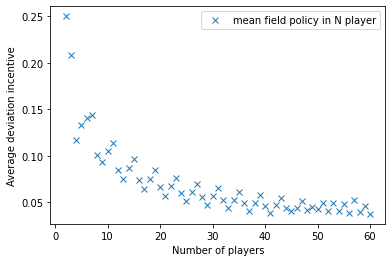

In [11]:
plt.plot(list(average_deviation_incentive_braess), list(average_deviation_incentive_braess.values()), 'x', label='mean field policy in N player')
plt.legend()
# plt.title('Average deviation incentive of the mean field policy in the N player game as a function of N.')
plt.xlabel('Number of players')
plt.ylabel('Average deviation incentive')
plt.show()